In [1]:
%pylab inline
np.set_printoptions(linewidth=120)
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams["legend.loc"] = "lower right"

Populating the interactive namespace from numpy and matplotlib


Set the path to the key file and change working-directory to the root directory of the dataprocessing framework

In [2]:
import os       
os.environ['DATAPRO_KEY'] = "/local/scratch/toolkit/benchmark_platforms_access/datapro_id_ed25519"
os.chdir('/local/scratch/toolkit/datapro/')
os.getcwd()

'/local/scratch/toolkit/datapro'

# Imports

In [3]:
import toml    as TOML              # TOML library to handle config files
import pandas  as pd                # Pandas for data manipulation
import seaborn as sb                # Statistical data visualisation
import pathlib as PATH              # Used to convert strings to path objects for (de-)serialisation
import types   as tp                # Library used for online method development

#from copy   import copy, deepcopy   # TODO
#from pprint import pprint           # TODO

# scikit-learn packets
import sklearn.base                 #
import sklearn.svm                  # LinearSVC, SVC
import sklearn.pipeline             # make_pipeline
import sklearn.preprocessing        # StandardScaler
import sklearn.decomposition        # PCA
import sklearn.naive_bayes          # GaussianNB
import sklearn.metrics              # CM

# DLE-Suite packets
import datapro                       # Dataprocessing
import datapro.experiment            # Experiment for execution
import datapro.util                  # General utilities
import datapro.layer                 # Data manipulation layers
from datapro.util       import *
from datapro.layer      import *
from datapro.channel    import *
from datapro.experiment import *

from datapro.util.attributedict import AttributeDict

# Generate Experiment
#### 1. Load config

In [4]:
config = TOML.load("./configurations/examples/thermal-cc_exploratory.toml")
print(TOML.dumps(config))

name = "Example_Sweep_Thermal"
save_path = "./data"
backup_path = "./data/_backup"
experiment_exists_action = "overwrite"

[EXPERIMENT]
type = "ExploratoryExperiment"
channel = "Thermal"

[EXPERIMENT.PHASES]

[EXPERIMENT.GENERAL]
latency = 10
fan = true
governors = "userspace"
frequencies = "max"
sampling_period = 0.001
delay_between_executions = 5.0
delay_after_bootstrap = 30.0
active_wait = false

[EXPERIMENT.LAYERS.io]
name = "TimeValue"

[EXPERIMENT.LAYERS.io.params]
timebase = "ns"

[ENVIRONMENTS.Radagast.APPS.snk]
executable = "meter_thermal_msr"
zone = "host"

[ENVIRONMENTS.Radagast.APPS.src]
executable = "generator_utilisation_mt"
zone = "host"

[ENVIRONMENTS.Radagast.src.generator]
cores = [ 5,]
policy = "round_robin"
priority = 99
worker_priority = 98

[ENVIRONMENTS.Radagast.src.logging]
debug_log_filename = ""
app_log_filename = ""
log_level = "info"

[ENVIRONMENTS.Radagast.src.schedule_reader]
input_file = ""
reading_from_file = true

[ENVIRONMENTS.Radagast.snk.logging]
deb

#### 2a Instantiate an experiment

Experiment factory will take the type and channel from the config.

In [5]:
channel    = ChannelFactory()(config["EXPERIMENT"]["channel"])
experiment = ExperimentFactory()(config["EXPERIMENT"]["type"], config=config, channel=channel)

2019-08-10 20:51:55 :: bootstrapped layer 'io' with TimeValue


#### 2b Define the phase traces (rdpstreams)
For the exploratory experiments, the user can freely design his own traces, in the form of rdpstreams. Those streams are added to the experiment config and used to instantiate the runs.
The rdpstreams will be deleted from the config during the generation process, to make sure that the serialised experiment does not get too big.

In [6]:
rdp_signals = [
                  pd.DataFrame(
                      # 10 periods of a rectangular waveform with 1Hz
                      data=np.hstack([np.full([20,1], 0.50), np.resize([1,0],[20,1])]), 
                      columns=['timestamp', 't440p']
                  ),
                  pd.DataFrame(
                      # 10 periods of a rectangular waveform with 2Hz
                      data=np.hstack([np.full([20,1], 0.25), np.resize([1,0],[20,1])]), 
                      columns=['timestamp', 't440p']
                  )
              ]
experiment.config.EXPERIMENT.PHASES = AttributeDict.from_dict(
    {'test':{'rdpstreams':rdp_signals,'repetitions':2}}
)

#### 2a Generate the experiment

In [7]:
experiment.generate()
experiment.print_duration()

2019-08-10 20:51:55 :: Estimated duration of a single repetition of the test phase is 0:00:15
2019-08-10 20:51:55 :: This results in a total estimated duration of 0:00:30 for all repetitions.


#### 3a. Eyeballing

You can access the streams via specific properties.

In [8]:
phase = "test"
rdpstream_id = 0
run = experiment.phases[phase][rdpstream_id]

# Access output streams
run.o_streams #-> mapping
#run.o_{bit,sym,lne,rdp,raw}stream
#print("-------------------------------- LNEstream -------------------------------------------------------")
#print(run.o_lnestream)
#print("-------------------------------- RDPstream -------------------------------------------------------")
#print(run.o_rdpstream)
#print("-------------------------------- Rawstream -------------------------------------------------------")
#print(run.o_rawstream)

{'rdpstream':     timestamp  t440p
 0         0.5    1.0
 1         0.5    0.0
 2         0.5    1.0
 3         0.5    0.0
 4         0.5    1.0
 5         0.5    0.0
 6         0.5    1.0
 7         0.5    0.0
 8         0.5    1.0
 9         0.5    0.0
 10        0.5    1.0
 11        0.5    0.0
 12        0.5    1.0
 13        0.5    0.0
 14        0.5    1.0
 15        0.5    0.0
 16        0.5    1.0
 17        0.5    0.0
 18        0.5    1.0
 19        0.5    0.0, 'rawstream':     timestamp  t440p
 0   500000000    1.0
 1   500000000    0.0
 2   500000000    1.0
 3   500000000    0.0
 4   500000000    1.0
 5   500000000    0.0
 6   500000000    1.0
 7   500000000    0.0
 8   500000000    1.0
 9   500000000    0.0
 10  500000000    1.0
 11  500000000    0.0
 12  500000000    1.0
 13  500000000    0.0
 14  500000000    1.0
 15  500000000    0.0
 16  500000000    1.0
 17  500000000    0.0
 18  500000000    1.0
 19  500000000    0.0}

#### 4. Write

Writes to disk, serialises the experiment, runs, and all streams.

In [9]:
experiment.write()

2019-08-10 20:51:55 :: experiment path 'data/Example_Sweep_Thermal' already exists, will be overwritten


## Execute

Running `execute` will execute in all environments present in the configuration.

In [10]:
#print("Available environments are: " + str(experiment.available_environments))
#experiment.execute_in_environment("Gandalf")
experiment.execute_in_environment("Radagast")

2019-08-10 20:51:55 :: Connected (version 2.0, client OpenSSH_7.6p1)
2019-08-10 20:51:55 :: Authentication (publickey) successful!
2019-08-10 20:51:56 :: Radagast->host: connected: SSHUnixDriver
2019-08-10 20:51:56 :: Radagast->host: sending experiment
2019-08-10 20:51:57 :: Radagast->host: experiment sent!
2019-08-10 20:51:57 :: Radagast->host: configuring to {'latency': 10, 'fan': True, 'governors': 'userspace', 'frequencies': 'max', 'sampling_period': 0.001, 'delay_between_executions': 5.0, 'delay_after_bootstrap': 30.0, 'active_wait': False}
2019-08-10 20:52:30 :: executing in env: Radagast, rep: 0, estimated duration: 10.0s, run: <Run at 0x7fc851f61ac8 (digested, config={'phase': 'test', 'rdpstream_id': 0, 'repetitions': 2})>
2019-08-10 20:52:43 :: Connected (version 2.0, client OpenSSH_7.6p1)
2019-08-10 20:52:43 :: Authentication (publickey) successful!
2019-08-10 20:52:48 :: executing in env: Radagast, rep: 1, estimated duration: 10.0s, run: <Run at 0x7fc851f61ac8 (digested, con

## Analyse

TODO: In the *analysis.local.ipynb* file in my workspace you can find a more complex example of an analysis.

#### 0. (Optional) Load from serialised experiment

Useful when you restarted the kernel, etc. Be aware that if you have the "move" option set up as the *experiment_exists_action* in the config, the older one will be timestamped and moved. To read it back, you can provide `replace=False` which handles the case where there are inconsistencies between the serialised experiment and the config files (primarily the experiment name, due to the timestamping). We discussed that quite a while ago, the result of the discussion was that the experiment should update itself with the config already present.

In [11]:
# path_to_serialised_experiment = PATH.Path("data/XXX/_experiment.pickle")
# TODO This is not working properly yet
path_to_serialised_experiment = PATH.Path("data/Example_Sweep_Thermal/_experiment.pickle")
#experiment = FrequencySweepExperiment.read(path_to_serialised_experiment, replace=False)

#### 1. Eyeballing single runs to check if experiment went well
##### 1a. Choose a run

In [13]:
phase = "test"
rdpstream_id = 0
run = experiment.phases[phase][rdpstream_id]; run

<Run at 0x7fc851f61ac8 (digested, config={'phase': 'test', 'rdpstream_id': 0, 'repetitions': 2})>

##### 1a. Get available environments

In [14]:
run.parent.layers.io.get_available_environments()

['Radagast']

##### 1b. Get raw measurements

- The `get_measurements` function requires the I/O layer to have at least the environment, and the repetition number configured.
- `describe_measurements` will tell you what columns are available, with more detail.

In [15]:
run.parent.layers.io.config.update(env="Radagast", rep=0)
measurements = run.parent.layers.io.get_measurements()
print(run.parent.layers.io.describe_measurements(measurements))

[{'module': 'host', 'value': 'timestamp', 'dimension': '', 'unit': 'ns', 'quantity': '', 'method': ''}, {'module': 'thermal_msr', 'value': 'core', 'dimension': '0', 'unit': '°C', 'quantity': 'thermal', 'method': 'msr'}, {'module': 'thermal_msr', 'value': 'core', 'dimension': '2', 'unit': '°C', 'quantity': 'thermal', 'method': 'msr'}, {'module': 'thermal_msr', 'value': 'core', 'dimension': '4', 'unit': '°C', 'quantity': 'thermal', 'method': 'msr'}, {'module': 'thermal_msr', 'value': 'core', 'dimension': '6', 'unit': '°C', 'quantity': 'thermal', 'method': 'msr'}]


The raw measurements are packed into a pandas DataFrame and can be used for eyeballing the data.

##### 1.c Ingest the run

To ingest the run, and pipe the measurements through the layers, you need to provide the necessary runtime configuration. Most of it is passed by default, with the notable exception of the *Matcher*.

The *Matcher* defines which columns will be taken from the raw measurements and passed on to the layers. For the thermal channel, you'd use:

```python
env = "Gandalf"
rep = 0
core = 4
matcher = wrangle.Matcher("thermal", "msr", ["core"], [core])
ingest_args = dict(io={"env": env, "rep": rep, "matcher": matcher})
```

You can also provide other parameters, e.g. the *decision device*. For eval runs, you'd have to get it from a train run, via `run.parent.layers.lne.decision_device` property.

In [16]:
ingest_args = dict(
#  io={"env": 'Radagast', "rep": 0, "matcher": datapro.util.wrangle.Matcher("thermal", "msr", ["core"], [2])}
  io={"env": 'Radagast', "rep": 0, "matcher": datapro.util.wrangle.Matcher("thermal", "msr", ["core"], list(range(0,1)))}
)
run.ingest(**ingest_args)

After running ingest, the run's input streams will be populated, and can be accessed via:

- `run.i_lnestream`
- `run.i_rdpstream`
- `run.i_rawstream`

##### 1d. Plot raw measurements

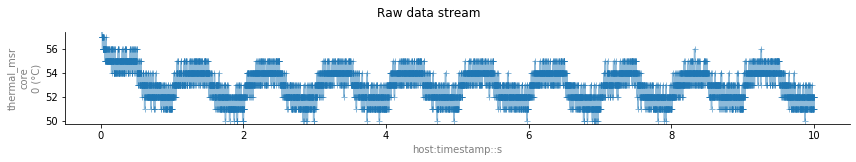

In [17]:
from datapro.plotting.run_plotter import *

with RunPlotter(run, save_pdf=False) as plotter:
    plotter.plot_rawstream(start=0, end=10)